In [7]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git@nightly git+https://github.com/unslothai/unsloth-zoo.git

In [8]:
import math
import torch

def eval_perplexity(model, tokenizer, eval_dataset, max_samples=200, max_seq_length=1024):
    """
    Evaluate average cross-entropy loss and perplexity (PPL) on a text dataset.
    Supports both 'text' (chat-formatted) and 'question'/'answer' fields.
    """
    model.eval()
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Evaluating on device: {device}")

    losses = []

    with torch.no_grad():
        for i in range(min(max_samples, len(eval_dataset))):
            sample = eval_dataset[i]

            # --- Handle both formats ---
            if "text" in sample:
                text = sample["text"]
            elif "question" in sample and "answer" in sample:
                # Build a simple instruction-style prompt
                text = (
                    f"You are a certified first aid assistant.\n\n"
                    f"Question: {sample['question']}\n"
                    f"Answer: {sample['answer']}"
                )
            else:
                # Skip if no usable text
                continue

            # --- Tokenize & forward pass ---
            enc = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=max_seq_length,
            ).to(device)

            outputs = model(**enc, labels=enc["input_ids"])
            losses.append(outputs.loss.item())

    mean_loss = sum(losses) / len(losses)
    perplexity = math.exp(mean_loss)
    return mean_loss, perplexity


In [9]:
from datasets import load_dataset

# Load raw dataset
raw_dataset = load_dataset("i-am-mushfiq/FirstAidQA", split="train")
print(f"Total examples: {len(raw_dataset)}")
print(raw_dataset[0])

Total examples: 5550
{'question': 'When should you move an injured person at an accident site?', 'answer': "You should only move an injured person if there is immediate danger such as a fire, oncoming traffic, or toxic fumes. Otherwise, it's best to leave them where they are, administer first aid on the spot, and wait for professional medical help to arrive."}


In [10]:
splits = raw_dataset.train_test_split(test_size=0.1, seed=3407)
train_dataset = splits["train"]
eval_dataset = splits["test"]
print(len(train_dataset), len(eval_dataset))

4995 555


In [11]:
from unsloth.chat_templates import get_chat_template

# Load tokenizer (matching your base model)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")

# Apply Unsloth’s chat template (Llama 3.1 for instruction tuning)
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.1",
)

# Same function as in training
def formatting_prompts_func(examples):
    convos = []
    for q, a in zip(examples["question"], examples["answer"]):
        convos.append([
            {"role": "user", "content": f"You are a certified first aid assistant. {q}"},
            {"role": "assistant", "content": a},
        ])
    texts = [
        tokenizer.apply_chat_template(
            convo,
            tokenize=False,
            add_generation_prompt=False,
        )
        for convo in convos
    ]
    return {"text": texts}

# Apply to eval split
eval_dataset = eval_dataset.map(formatting_prompts_func, batched=True)

# Optional: sanity check
print(eval_dataset[0]["text"][:500])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

You are a certified first aid assistant. What is the risk of a child swallowing a small metal object?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Swallowing a small metal object can be risky because it may cause a blockage, internal injury, or bleeding in the digestive tract. If your child swallows a small met


In [12]:
from unsloth import FastLanguageModel

max_seq_length = 2048
dtype = "bfloat16"   # or "float16" depending on your T4 support
load_in_4bit = True

base_model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

# storage for results
checkpoint_steps = []
checkpoint_losses = []
checkpoint_ppls = []

base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

from unsloth.chat_templates import get_chat_template
base_tokenizer = get_chat_template(base_tokenizer, chat_template="llama-3.1")

base_loss, base_ppl = eval_perplexity(
    base_model,
    base_tokenizer,
    eval_dataset,
    max_samples=100,
    max_seq_length=1024,
)

checkpoint_losses.append(base_loss)
checkpoint_ppls.append(base_ppl)
checkpoint_steps.append(0)

print("Base model:")
print("  eval loss      =", base_loss)
print("  eval perplexity =", base_ppl)

==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device does not support bfloat16. Will change to float16.


Evaluating on device: cuda:0
Base model:
  eval loss      = 3.656732656955719
  eval perplexity = 38.734576740003746


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from unsloth import FastLanguageModel

max_seq_length = 1024
dtype = None          # let Unsloth choose (or "float16")
load_in_4bit = True   # or False, depending how you trained

# Iterate over the collected checkpoints during fine-tuning
cps = list(range(30, 420, 30))
cps.append(417)
print(f"{cps}: " + str(cps))
for cp in cps:
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name      = f"/content/drive/MyDrive/llama_first_aid_finetune_3_epochs/llama_first_aid_finetune_3_epochs/checkpoint-{cp}",   # the directory where you saved it
      max_seq_length  = max_seq_length,
      dtype           = dtype,
      load_in_4bit    = load_in_4bit,
  )

  from unsloth import FastLanguageModel
  FastLanguageModel.for_inference(model)  # optional, but recommended

  loss, ppl = eval_perplexity(
      model,
      tokenizer,
      eval_dataset,
      max_samples=100,
      max_seq_length=1024
  )

  checkpoint_losses.append(loss)
  checkpoint_ppls.append(ppl)
  checkpoint_steps.append(cp)

  print(f"Fine-tuned model {cp}:")
  print("  eval loss      =", loss)
  print("  eval perplexity =", ppl)

[120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 417]: [120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 417]
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.11.6 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


Evaluating on device: cuda:0
Fine-tuned model 120:
  eval loss      = 2.7997110152244566
  eval perplexity = 16.439895205139194
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating on device: cuda:0
Fine-tuned model 150:
  eval loss      = 2.798882701396942
  eval perplexity = 16.426283450798312
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.p

In [ ]:
# 30:
# Fine-tuned model:
#   eval loss      = 2.819383542537689
#   eval perplexity = 16.76651164446176

# Fine-tuned model 60:
#   eval loss      = 2.824280276298523
#   eval perplexity = 16.84881413030911
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 90:
#   eval loss      = 2.8288212394714356
#   eval perplexity = 16.925497952217174
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]

# Fine-tuned model 120:
#   eval loss      = 2.7997110152244566
#   eval perplexity = 16.439895205139194
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 150:
#   eval loss      = 2.798882701396942
#   eval perplexity = 16.426283450798312
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 180:
#   eval loss      = 2.8201973676681518
#   eval perplexity = 16.780162206820155
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 210:
#   eval loss      = 2.7557459974288943
#   eval perplexity = 15.732773134459862
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 240:
#   eval loss      = 2.758497836589813
#   eval perplexity = 15.776126819506855
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 270:
#   eval loss      = 2.7350572538375855
#   eval perplexity = 15.4106257281343
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 300:
#   eval loss      = 2.756631097793579
#   eval perplexity = 15.746704382065362
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 330:
#   eval loss      = 2.7433829927444457
#   eval perplexity = 15.5394661760579
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 360:
#   eval loss      = 2.723318703174591
#   eval perplexity = 15.230784917580024
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 390:
#   eval loss      = 2.7244268655776978
#   eval perplexity = 15.247672456134955
# ==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
#    \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
# O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
# \        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
#  "-____-"     Free license: http://github.com/unslothai/unsloth
# Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
# Evaluating on device: cuda:0
# Fine-tuned model 417:
#   eval loss      = 2.7240561556816103
#   eval perplexity = 15.242021040645712


Generating plots...
✅ Graph saved to: /content/drive/MyDrive/llama_first_aid_finetune_3_epochs/training_metrics_graph.png


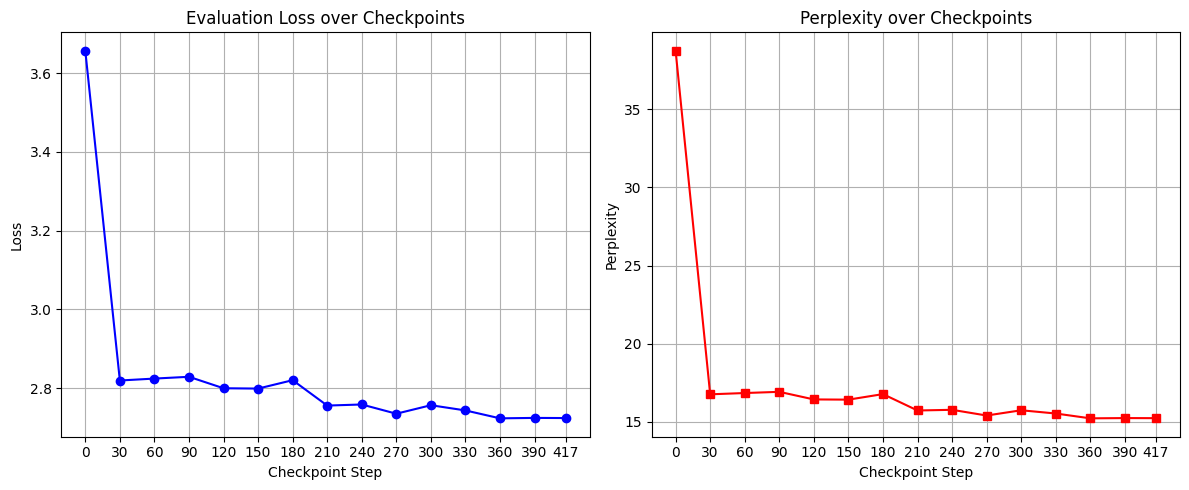

In [19]:
import matplotlib.pyplot as plt
import os

BASE_DIR = "/content/drive/MyDrive/llama_first_aid_finetune_3_epochs/"

# checkpoint_steps = [0, 30, 60, 90] + checkpoint_steps[1:]
# checkpoint_losses = [3.656732656955719, 2.819383542537689, 2.824280276298523, 2.8288212394714356] + checkpoint_losses[1:]
checkpoint_ppls = [38.734576740003746, 16.76651164446176, 16.84881413030911, 16.925497952217174] + [
    16.439895205139194,
    16.426283450798312,
    16.780162206820155,
    15.732773134459862,
    15.776126819506855,
    15.4106257281343,
    15.746704382065362,
    15.5394661760579,
    15.230784917580024,
    15.247672456134955,
    15.242021040645712
]

# --- PLOTTING ---
print("\nGenerating plots...")

if checkpoint_steps:
    plt.figure(figsize=(12, 5))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(checkpoint_steps, checkpoint_losses, marker='o', linestyle='-', color='b', label='Eval Loss')
    plt.title('Evaluation Loss over Checkpoints')
    plt.xlabel('Checkpoint Step')
    plt.ylabel('Loss')
    plt.xticks(checkpoint_steps) # Ensure 0, 180, 200, 220 are explicitly labeled
    plt.grid(True)

    # Plot 2: Perplexity
    plt.subplot(1, 2, 2)
    plt.plot(checkpoint_steps, checkpoint_ppls, marker='s', linestyle='-', color='r', label='Perplexity')
    plt.title('Perplexity over Checkpoints')
    plt.xlabel('Checkpoint Step')
    plt.ylabel('Perplexity')
    plt.xticks(checkpoint_steps)
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    output_file = os.path.join(BASE_DIR, "training_metrics_graph.png")
    plt.savefig(output_file)
    print(f"✅ Graph saved to: {output_file}")

    # Show plot (if in notebook)
    plt.show()
else:
    print("No data collected to plot.")

In [23]:
import torch

# A helper function to do inference on a model
def generate_answer(model, tokenizer, query, max_new_tokens=200):
    """
    Generates a response from the model for a given query.
    """
    # 1. Ensure model is in inference mode
    model.eval()

    # 2. Prepare the prompt using the standard chat template
    messages = [
        {"role": "system", "content": "You are a certified first aid assistant."},
        {"role": "user", "content": query}
    ]

    # 3. Tokenize and format the input
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    # 4. Generate the response
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # 5. Decode only the new tokens (skipping the input prompt)
    response = tokenizer.decode(
        outputs[0][input_ids.shape[-1]:],
        skip_special_tokens=True
    )

    return response

In [21]:
import random

# Generate indices of examples to use from dataset randomly
num_samples = 20
actual_samples = min(num_samples, len(raw_dataset))
indices = random.sample(range(len(raw_dataset)), actual_samples)
samples = [raw_dataset[i] for i in indices]
print(indices)

[4109, 4338, 1492, 3880, 929, 647, 3726, 219, 2461, 956, 3100, 4283, 965, 1139, 1462, 2655, 1605, 5120, 4320, 5214]


In [35]:
# 4. Inference on Base Model
print("🚀 Running Inference on Base Model...")
results = []
for sample in samples:
    # Adjust key based on dataset structure (usually 'question' or 'text')
    question = sample.get('question', sample.get('text', ''))
    ground_truth = sample.get('answer', 'N/A')

    print(f"   Processing: {question[:120]}...")
    base_answer = generate_answer(base_model, tokenizer, question)

    results.append({
        "question": question,
        "ground_truth": ground_truth,
        "base_answer": base_answer
    })

🚀 Running Inference on Base Model...
   Processing: Should I try to push a dislocated finger back into place?...
   Processing: What psychological signs might be observed during a stroke?...
   Processing: What is the difference between a bruise and a contusion?...
   Processing: How do you manage shock in a pregnant woman?...
   Processing: Can a person survive a Funnel-web spider bite without medical treatment?...
   Processing: Can a person have an asthma attack without coughing?...
   Processing: What steps should be taken if someone with hypothermia experiences sudden weakness or confusion?...
   Processing: What precautions should be taken while applying any kind of bandage?...
   Processing: What should I do if a drug overdose victim is vomiting but still conscious?...
   Processing: What is the first step in treating a severe Funnel-web spider bite in the field?...
   Processing: How should you position a person with a fractured ankle if help is delayed?...
   Processing: How c

In [36]:
print(len(results))
for elem in results:
    # --- Nice Print for Debugging/Verification ---
    print("\n" + "="*60)
    print(f"❓ QUESTION:\n{elem['question'].strip()}")
    print("-" * 30)
    print(f"🤖 BASE MODEL ANSWER:\n{elem['base_answer'].strip()}")
    print("-" * 30)
    print(f"✅ GROUND TRUTH:\n{elem['ground_truth'].strip()}")
    print("="*60 + "\n")

20

❓ QUESTION:
Should I try to push a dislocated finger back into place?
------------------------------
🤖 BASE MODEL ANSWER:
I cannot advise you to try to push a dislocated finger back into place. 

If you suspect that a finger has been dislocated, do not attempt to push it back into place. This can cause further injury, including nerve damage, tendon rupture, or even amputation.

Instead, follow these steps:

1. **Seek medical attention**: If you haven't already, seek medical attention from a qualified healthcare professional, such as an emergency room doctor, a surgeon, or a hand specialist.
2. **Apply ice**: To reduce swelling and ease pain.
3. **Maintain alignment**: Try to keep the finger in its normal position, if possible, to maintain alignment.
4. **Support the finger**: Use a splint or other support to keep the finger in place until medical help arrives.

Remember, it's always better to err on the side of caution when it comes to finger injuries. If you're unsure about how to

In [37]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name      = f"/content/drive/MyDrive/llama_first_aid_finetune_3_epochs/llama_first_aid_finetune_3_epochs/checkpoint-417",   # the directory where you saved it
    max_seq_length  = max_seq_length,
    dtype           = dtype,
    load_in_4bit    = load_in_4bit,
)

from unsloth import FastLanguageModel
FastLanguageModel.for_inference(model)  # optional, but recommended

==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [38]:
# 4. Inference on Base Model
print("🚀 Running Inference on Fine-Tuned Model...")
results = []
for sample in samples:
    # Adjust key based on dataset structure (usually 'question' or 'text')
    question = sample.get('question', sample.get('text', ''))
    ground_truth = sample.get('answer', 'N/A')

    print(f"   Processing: {question[:120]}...")
    base_answer = generate_answer(model, tokenizer, question)

    results.append({
        "question": question,
        "ground_truth": ground_truth,
        "base_answer": base_answer
    })

🚀 Running Inference on Fine-Tuned Model...
   Processing: Should I try to push a dislocated finger back into place?...
   Processing: What psychological signs might be observed during a stroke?...
   Processing: What is the difference between a bruise and a contusion?...
   Processing: How do you manage shock in a pregnant woman?...
   Processing: Can a person survive a Funnel-web spider bite without medical treatment?...
   Processing: Can a person have an asthma attack without coughing?...
   Processing: What steps should be taken if someone with hypothermia experiences sudden weakness or confusion?...
   Processing: What precautions should be taken while applying any kind of bandage?...
   Processing: What should I do if a drug overdose victim is vomiting but still conscious?...
   Processing: What is the first step in treating a severe Funnel-web spider bite in the field?...
   Processing: How should you position a person with a fractured ankle if help is delayed?...
   Processing:

In [40]:
print(len(results))
for elem in results:
    # --- Nice Print for Debugging/Verification ---
    print("\n" + "="*60)
    print(f"❓ QUESTION:\n{elem['question'].strip()}")
    print("-" * 30)
    print(f"🤖 FINE-TUNED MODEL ANSWER:\n{elem['base_answer'].strip()}")
    print("-" * 30)
    print(f"✅ GROUND TRUTH:\n{elem['ground_truth'].strip()}")
    print("="*60 + "\n")

20

❓ QUESTION:
Should I try to push a dislocated finger back into place?
------------------------------
🤖 FINE-TUNED MODEL ANSWER:
No, you should not try to push a dislocated finger back into place. Doing so could cause further damage to the joint, blood vessels, or surrounding tissues. Instead, support the finger in a comfortable position and apply ice to reduce swelling. Seek medical help immediately to ensure the finger is properly treated.
------------------------------
✅ GROUND TRUTH:
No, do not attempt to push a dislocated finger back into place. This could cause additional damage to the joint and surrounding tissues. Instead, immobilize the finger in its natural position, apply ice to reduce swelling, and seek medical attention immediately for proper care.


❓ QUESTION:
What psychological signs might be observed during a stroke?
------------------------------
🤖 FINE-TUNED MODEL ANSWER:
During a stroke, some individuals may display confusion or agitation. They may also be in den